## Forward Floes using Ice Velocity Data
Heather Tweedie  
March 2024

This notebook tracks forward a number of points in the Arctic using ice drift velocity data. Points are selected from the MISR sea ice roughness grid by index. These can be replaced by lats and lons if desired at the top of the first cell in the section titled 'Configure points to be forwarded'.  
Based on code by ...?

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, MFDataset
import pandas as pd
from scipy import spatial
from datetime import datetime
from datetime import timedelta
import os.path
import h5py as h5

In [16]:
YEAR = 2019
START_DATE = f'{YEAR}-04-01 12:00:00'
DAYS_TO_FORWARD = 120

### Load MISR roughness data

In [17]:
def load_MISR(MISR_path):
    '''Loads MISR data and coordinates from specified file path.

    Params:
        MISR_path (str): the file path from which to retrieve data

    Returns:
        data (np.array): roughness data retrieved from the specified file
        lon, lat
        x, y
    '''

    file = h5.File(MISR_path, 'r')
    
    # extract coord data
    lon = np.array(file['GeoLocation']['Longitude'])
    lat = np.array(file['GeoLocation']['Latitude'])
    x = np.array(file['GeoLocation']['x'])
    y = np.array(file['GeoLocation']['y'])

    # extract roughness data
    data = np.array(file['Roughness']['Roughness_2D_svm'])    
    
    file.close()

    return data, lon, lat, x, y


# retrieve MISR data and coordinates
fn = f'/home/ssureen/MISR_data_monthly/April {YEAR} Roughness.h5'
sigma, sigma_lon, sigma_lat, sigma_x, sigma_y = load_MISR(fn)


Text(0.5, 1.0, 'MISR Sea Ice Roughness for April 2019')

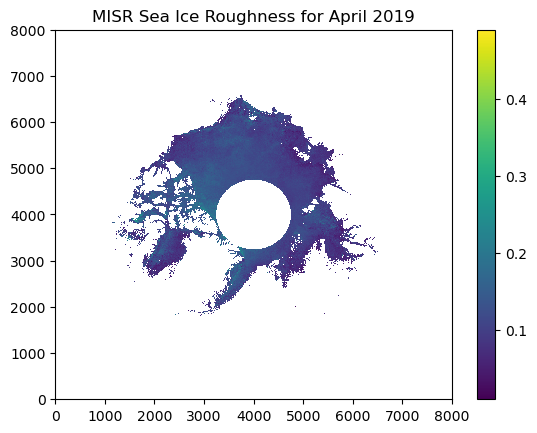

In [18]:
plt.pcolormesh(sigma)
plt.colorbar()
plt.title(f'MISR Sea Ice Roughness for April {YEAR}')


### Inspect ice drift data files

Example file:

In [19]:
! ls /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/09/ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200.nc

/home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/09/ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200.nc


Look at example file:

In [20]:
! ncdump -h /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/09/ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200.nc

netcdf ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200 {
dimensions:
	time = 1 ;
	nv = 2 ;
	xc = 119 ;
	yc = 177 ;
variables:
	int Polar_Stereographic_Grid ;
		Polar_Stereographic_Grid:grid_mapping_name = "polar_stereographic" ;
		Polar_Stereographic_Grid:straight_vertical_longitude_from_pole = -45.f ;
		Polar_Stereographic_Grid:latitude_of_projection_origin = 90.f ;
		Polar_Stereographic_Grid:standard_parallel = 70.f ;
		Polar_Stereographic_Grid:false_easting = 0.f ;
		Polar_Stereographic_Grid:false_northing = 0.f ;
		Polar_Stereographic_Grid:semi_major_axis = 6378273.f ;
		Polar_Stereographic_Grid:semi_minor_axis = 6356890.f ;
		Polar_Stereographic_Grid:proj4_string = "+proj=stere +a=6378273 +b=6356889.44891 +lat_0=90 +lat_ts=70 +lon_0=-45" ;
	double time(time) ;
		time:axis = "T" ;
		time:long_name = "reference time of product" ;
		time:standard_name = "time" ;
		time:units = "seconds since 1978-01-01 00:00:00" ;
		time:calendar = "standard" ;
		time:bounds = "time_bnds

Available years: (2009 and 2024 are incomplete)

In [21]:
! ls /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/


2009  2011  2013  2015	2017  2019  2021  2023
2010  2012  2014  2016	2018  2020  2022  2024


In [22]:
# load the example file
#OSISAFfile = '/Users/micheltsamados/Google Drive/ADMINISTRATION/MosaicNERC2018/FieldTrip/WORK/DriftRackow/drift-velocities/archive/ice/drift_lr/merged/2017/09/ice_drift_nh_polstere-625_multi-oi_201708301200-201709011200.nc'
OSISAFfile = '/home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/09/ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200.nc'
fl = Dataset(OSISAFfile)
#xc=fl.variables['xc']
#yc=fl.variables['yc']
#XC,YC=np.meshgrid(xc,yc)

# lon lat on grid
lon_start=np.copy(fl.variables['lon'])
lat_start=np.copy(fl.variables['lat'])

# lon lat at the end of the displacement
lon_end=np.squeeze(fl.variables['lon1'][0,:,:])
lat_end=np.squeeze(fl.variables['lat1'][0,:,:])

# max and min start and end coords
lon_end.min(), lon_end.max(), lon_start.min(), lon_start.max()

(-179.70926, 179.05727, -180.0, 179.52649)

### Define class and functions to be used

In [23]:
class Buoys:
    
    global rad, r_earth
    rad=np.pi/180.0 # radiant <-> degree
    r_earth=6.3675*10**6 # radius of Earth in [m]
    
    def __init__(self, lon_start, lat_start, earliest_date_of_buoy, start_advect_date):
        print(lon_start)
        self.oldlon = lon_start * rad
        self.oldlat = lat_start * rad
        self.lon = lon_start * rad
        self.lat = lat_start * rad
        self.initlon = lon_start * rad
        self.initlat = lat_start * rad
        self.old_u = np.zeros(lon_start.shape)
        self.old_v = np.zeros(lon_start.shape)
        self.date = datetime.strptime(earliest_date_of_buoy, "%Y-%m-%d %H:%M:%S")
        self.startdates = start_advect_date
        #self.delta_x = np.zeros(lon_start.shape)
        #self.delta_y = np.zeros(lon_start.shape)
        #self.u_ice = np.zeros(lon_start.shape)
        #self.v_ice = np.zeros(lon_start.shape)
        
    def getdate(self):
        return self.date.strftime("%Y-%m-%d %H:%M:%S")
        
    def trajectory(self, new_u, new_v, delta_t):
        print("Update buoy positions. Integrate for " + str(delta_t/3600.) + " hours.")
        
        #save old position in case the drifter leaves the domain
        self.oldlon = self.lon # radiant
        self.oldlat = self.lat # radiant
        
        #displacement vectors
        deltax1 = self.old_u * delta_t
        deltay1 = self.old_v * delta_t
        deltax2 = new_u * delta_t
        deltay2 = new_v * delta_t
        
        #Heun method (2nd order)
        self.lon = self.lon + (0.5*(deltax1 + deltax2) / (r_earth*np.cos(self.lat.values)) )
        self.lat = self.lat + (0.5*(deltay1 + deltay2) /  r_earth )
        
        # keep degree in range 0..360 and -90..90
        lon_deg = self.lon/rad % 360
        lat_deg = np.clip(self.lat/rad, -90., 90.)
        self.lon = lon_deg*rad
        self.lat = lat_deg*rad
        
        #update velocity here (old value was needed for heun method)
        self.old_u=new_u
        self.old_v=new_v
        
        # set positions to NaN before the buoy is supposed to move
        #idx=getindices_beforestart(self.getdate(), self.startdates)
        #lon_deg[idx] = np.nan
        #lat_deg[idx] = np.nan
        #self.lon[idx] = self.initlon[idx]
        #self.lat[idx] = self.initlat[idx]
        #self.old_u[idx]=0.
        #self.old_v[idx]=0.
        
        # update time stamp
        self.date = self.date + timedelta(seconds=delta_t)

        return lon_deg, lat_deg


In [24]:
r_earth=6.3675*10**6 # radius of Earth in [m]
rad=np.pi/180.0 # radiant <-> degree

# a useful function we'll need
def length_of_latitude_circle(lat=85.):
    return 2*np.pi*r_earth*np.cos(lat*rad) / 1000. # km


# find the buoys that are not to be advected yet (current date < start date)
def getindices_beforestart(currentdate, startdates):
        
    indices=np.zeros(np.shape(startdates),dtype='bool')
    for i,val in enumerate(startdates):
        # don't advect yet
        if currentdate < startdates[i]:
            indices[i]=True
            
    return indices


# load OSISAF data for Northern Hemisphere at a certain date
def loaddate_ofOSISAF(datestring, hemisphere='nh'):
    
    # convert datestring to datetime object
    thedate = datetime.strptime(datestring, "%Y-%m-%d %H:%M:%S")
    
    # let's construct the file name, 
    # e.g. drift-velocities/archive/ice/drift_lr/merged/2019/09/
    # ice_drift_nh_polstere-625_multi-oi_201909011200-201909031200.nc
    pathtofile = "/home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/"
    # middle part
    middlefilename="ice_drift_"+hemisphere+"_polstere-625_multi-oi_"
    # e.g. 201907291200-201907311200 (48hr span)
    enddate=thedate + timedelta(days=2)
    # YYYY/MM/ (from end date)
    YYYYMM=enddate.strftime("%Y")+"/"+enddate.strftime("%m")+"/"
    endfilename= thedate.strftime("%Y%m%d%H%M") + "-" + enddate.strftime("%Y%m%d%H%M") + '.nc'
    
    # the OSISAF file to be loaded
    filename=pathtofile + YYYYMM + middlefilename + endfilename
    
    # take previous files in case there is a data gap
    sd=thedate
    ed=enddate
    while os.path.isfile(filename)!=True:
        # try previous file
        sd=sd - timedelta(days=1)
        ed=ed - timedelta(days=1)
        # YYYY/MM/ (from end date)
        YYYYMM=ed.strftime("%Y")+"/"+ed.strftime("%m")+"/"
        endfilename= sd.strftime("%Y%m%d%H%M") + "-" + ed.strftime("%Y%m%d%H%M") + '.nc'
        filename=pathtofile + YYYYMM + middlefilename + endfilename
        print('data gap: try previous file '+filename+' ...')
    
    print("loading "+filename+ " ...") # Python3 needs brackets here
    
    # load the file
    fl = Dataset(filename)
    #xc=fl.variables['xc']
    #yc=fl.variables['yc']
    #XC,YC=np.meshgrid(xc,yc)
    
    # lon lat on grid
    lon_start=np.copy(fl.variables['lon'])
    lat_start=np.copy(fl.variables['lat'])

    # lon lat at the end of the displacement
    lon_end=np.squeeze(fl.variables['lon1'][0,:,:])
    lat_end=np.squeeze(fl.variables['lat1'][0,:,:])
    
    # close the file
    fl.close()
    
    # compute Ufield from end points and start points (48hour change)
    deltalon=lon_end-lon_start
    deltalon[deltalon>100.]=deltalon[deltalon>100.]-360.   # jump at -180..180
    deltalon[deltalon<-100.]=deltalon[deltalon<-100.]+360. # jump at -180..180
    Ufield=deltalon/48. *length_of_latitude_circle(lat=lat_start[:,:])/360. / 3.6 # km/h -> m/s
    
    # compute Vfield as well
    Vfield=(lat_end-lat_start)/48. *length_of_latitude_circle(lat=0.)/360. / 3.6 #km/h -> m/s
    
    return Ufield, Vfield, lon_start, lat_start


# nearest-neighbor interpolation, finds U,V at the position of the buoys using a fast KDTree method
def find_UV_atbuoy_pos(lon_start,lat_start, Ufield,Vfield, objects):
    
    # (lon,lat) tuples of the underlying grid
    A = np.array([lon_start[:,:].flatten(), lat_start[:,:].flatten()]).T # -180..180 assumed in OSISAF
    # change to -180..180 as assumed in OSISAF data; in the trajectory code its 0..360
    lon_adjust = objects.lon/rad
    lon_adjust[lon_adjust>180.] = lon_adjust[lon_adjust>180.]-360.
    # zip buoy (lon & lat) arrays to (lon,lat) tuples
    tuples = np.column_stack((lon_adjust, objects.lat/rad)) 
    # fast KDTree nearest neighbor method
    idx = spatial.KDTree(A).query(tuples)[1]
    
    return Ufield[idx], Vfield[idx]


In [32]:
# test the function (sometimes there are data gaps that need to be handled)
# datstrings are always yyyy-mm-dd 12:00:00
datestring='2020-05-30 12:00:00'
Ufield, Vfield, lon_start, lat_start = loaddate_ofOSISAF(datestring, hemisphere='nh')

loading /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2020/06/ice_drift_nh_polstere-625_multi-oi_202005301200-202006011200.nc ...


In [33]:
point_lats = (sigma_lat[4000,3000], sigma_lat[4100,3200], sigma_lat[4200,3400], sigma_lat[4300,3600], sigma_lat[4400,3800], sigma_lat[4500,4000])
point_lons = (sigma_lon[4000,3000], sigma_lon[4100,3200], sigma_lon[4200,3400], sigma_lon[4300,3600], sigma_lon[4400,3800], sigma_lon[4500,4000])
print(f'lats: {point_lats}')
print(f'lons: {point_lons}')
num_points = len(point_lats)
delta_t = 86400

earliest_date = START_DATE
advect_start_date = START_DATE
dates = [advect_start_date]

lons = np.zeros((1, num_points))*np.nan
lats = np.zeros((1, num_points))*np.nan
lons_df = pd.DataFrame(data=lons, index=dates)
lats_df = pd.DataFrame(data=lats, index=dates)

lats_df.loc[advect_start_date] = point_lats
lons_df.loc[advect_start_date] = point_lons

# Construct U,V sea ice velocity here for plotting
# calculate magnitude of velocities and store as plotfield
deltalon = lon_end-lon_start
deltalon[deltalon>100.] = deltalon[deltalon>100.]-360. # jump at -180..180
deltalon[deltalon<-100.] = deltalon[deltalon<-100.]+360. # jump at -180..180
Ufield=deltalon/48. *length_of_latitude_circle(lat=lat_start[:,:])/360. * 3.6 # km/h -> m/s
Vfield=(lat_end-lat_start)/48. *length_of_latitude_circle(lat=0.)/360. * 3.6 #km/h -> m/s
plotfield = np.squeeze(np.sqrt(Ufield**2 + Vfield**2)) # m/s
#plotfield=Ufield


lats: (81.04159, 82.780556, 84.337944, 85.52314, 85.993195, 85.51777)
lons: (-90.02866, -97.1647, -108.49227, -126.95013, -153.52084, 179.94276)


/tmp/ipykernel_363242/4203296932.py:27: RuntimeWarning: invalid value encountered in sqrt
  plotfield = np.squeeze(np.sqrt(Ufield**2 + Vfield**2)) # m/s


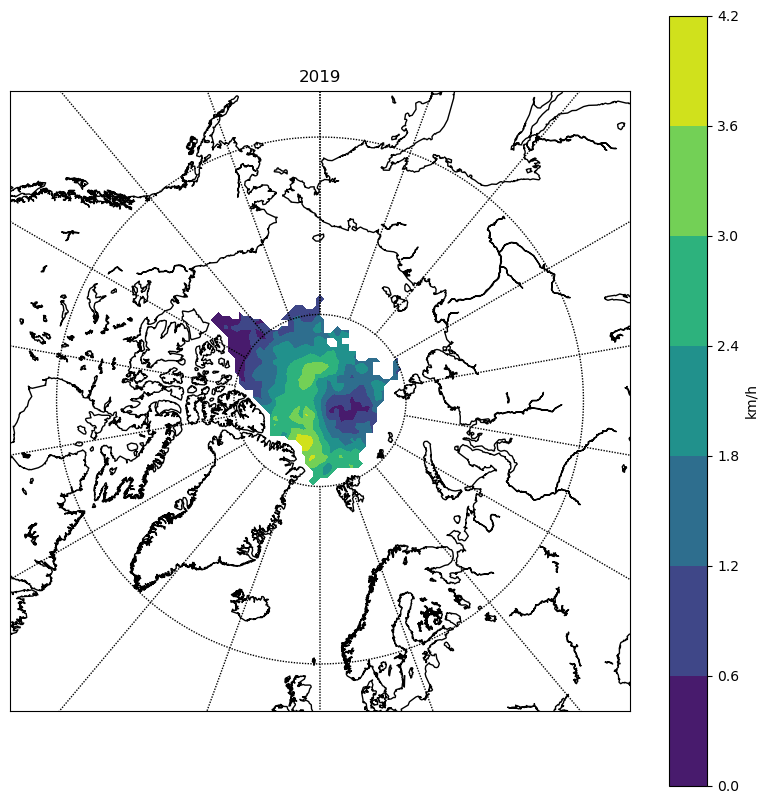

In [34]:
fig = plt.figure(figsize=(10,10))
plt.set_cmap('viridis')
m = Basemap(projection='npstere',boundinglat=55,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')

m.drawcoastlines()
#m.fillcontinents(color='0.1',lake_color='lightblue')

# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
#m.drawmapboundary(fill_color='lightblue')

lon_map,lat_map=m(lon_start[:,:],lat_start[:,:])
m.contourf(lon_map, lat_map, plotfield, vmin=0)

cbar=plt.colorbar()
cbar.set_label('km/h')
plt.title(f'{2019}')
plt.show()


### Configure points to be forwarded

In [13]:
# six sample points from the MISR roughness data grid. Indexed points can be replaced with true lats and lons
point_lats = (sigma_lat[4000,3000], sigma_lat[4100,3200], sigma_lat[4200,3400], sigma_lat[4300,3600], sigma_lat[4400,3800], sigma_lat[4500,4000])
point_lons = (sigma_lon[4000,3000], sigma_lon[4100,3200], sigma_lon[4200,3400], sigma_lon[4300,3600], sigma_lon[4400,3800], sigma_lon[4500,4000])
print(f'lats: {point_lats}')
print(f'lons: {point_lons}')
num_points = len(point_lats)
delta_t = 86400

earliest_date = START_DATE
advect_start_date = START_DATE
dates = [advect_start_date]

lons = np.zeros((1, num_points))*np.nan
lats = np.zeros((1, num_points))*np.nan
lons_df = pd.DataFrame(data=lons, index=dates)
lats_df = pd.DataFrame(data=lats, index=dates)

lats_df.loc[advect_start_date] = point_lats
lons_df.loc[advect_start_date] = point_lons 

points = Buoys(lons_df.loc[advect_start_date], lats_df.loc[advect_start_date], advect_start_date, earliest_date)


lats: (81.04159, 82.780556, 84.337944, 85.52314, 85.993195, 85.51777)
lons: (-90.02866, -97.1647, -108.49227, -126.95013, -153.52084, 179.94276)
0    -90.028664
1    -97.164703
2   -108.492271
3   -126.950127
4   -153.520844
5    179.942764
Name: 2019-04-01 12:00:00, dtype: float64


### Forward points

In [14]:
for i in np.arange(1, DAYS_TO_FORWARD+1):
    print('This is loop #'+str(i))

    Ufield, Vfield, lon_start, lat_start = loaddate_ofOSISAF(points.getdate(), hemisphere='nh')
    U,V = find_UV_atbuoy_pos(lon_start, lat_start, Ufield.flatten(),Vfield.flatten(), points)

    # don't advect buoys when there is no ice
    fixed=np.logical_or(U.mask, V.mask)
    U[fixed]=0.
    V[fixed]=0.

    LON,LAT = points.trajectory(U, V, delta_t=delta_t) # U,V in m/s, delta_t in seconds

    # create dataframe with new lats and lons
    new_lons = pd.DataFrame(LON.rename(points.getdate())).T
    new_lats = pd.DataFrame(LAT.rename(points.getdate())).T

    # add dataframe with new lats and lons to original one
    lons_df = pd.concat([lons_df, new_lons])
    lats_df = pd.concat([lats_df, new_lats])



This is loop #1
loading /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/04/ice_drift_nh_polstere-625_multi-oi_201904011200-201904031200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #2
loading /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/04/ice_drift_nh_polstere-625_multi-oi_201904021200-201904041200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #3
loading /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/04/ice_drift_nh_polstere-625_multi-oi_201904031200-201904051200.nc ...


Update buoy positions. Integrate for 24.0 hours.
This is loop #4
loading /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/04/ice_drift_nh_polstere-625_multi-oi_201904041200-201904061200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #5
loading /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/04/ice_drift_nh_polstere-625_multi-oi_201904051200-201904071200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #6
loading /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/04/ice_drift_nh_polstere-625_multi-oi_201904061200-201904081200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #7
loading /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/04/ice_drift_nh_polstere-625_multi-oi_201904071200-201904091200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #8
loading /home/htweedie/melt_ponds/d

In [15]:
lons_df

,0,1,2,3,4,5
2019-04-01 12:00:00,-90.028664,-97.164703,-108.492271,-126.950127,-153.520844,179.942764
2019-04-02 12:00:00,269.971336,262.857284,251.536906,233.236338,206.865536,180.274150
2019-04-03 12:00:00,269.971336,262.838112,251.590528,233.545852,207.474077,180.852190
2019-04-04 12:00:00,269.971336,262.794916,251.630893,233.749123,207.783771,181.174045
2019-04-05 12:00:00,269.971336,262.778707,251.647352,233.898277,207.891258,181.225703
...,...,...,...,...,...,...
2019-07-26 12:00:00,269.971336,257.138728,248.486959,247.737754,220.112278,168.322229
2019-07-27 12:00:00,269.971336,256.460566,248.088064,247.318131,219.565909,164.754767
2019-07-28 12:00:00,269.971336,255.906669,247.450168,246.398893,218.100656,162.557862
2019-07-29 12:00:00,269.971336,255.738885,247.184593,245.769553,216.860688,160.537382


In [16]:
lats_df

,0,1,2,3,4,5
2019-04-01 12:00:00,81.041588,82.780556,84.337944,85.523140,85.993195,85.517769
2019-04-02 12:00:00,81.041588,82.772556,84.329500,85.507509,85.979464,85.527365
2019-04-03 12:00:00,81.041588,82.754082,84.309519,85.476671,85.958868,85.544830
2019-04-04 12:00:00,81.041588,82.739426,84.291920,85.455273,85.950573,85.561476
2019-04-05 12:00:00,81.041588,82.734983,84.287802,85.447004,85.949699,85.570097
...,...,...,...,...,...,...
2019-07-26 12:00:00,81.041588,81.640942,83.679640,85.767685,87.882368,89.370737
2019-07-27 12:00:00,81.041588,81.590137,83.619045,85.745602,87.906344,89.454321
2019-07-28 12:00:00,81.041588,81.534500,83.579210,85.711023,87.880625,89.467463
2019-07-29 12:00:00,81.041588,81.496649,83.568470,85.697441,87.850134,89.435314


### Plot trajectories:

In [18]:
# Construct U,V sea ice velocity here for plotting
# calculate magnitude of velocities and store as plotfield
deltalon = lon_end-lon_start
deltalon[deltalon>100.] = deltalon[deltalon>100.]-360. # jump at -180..180
deltalon[deltalon<-100.] = deltalon[deltalon<-100.]+360. # jump at -180..180
Ufield=deltalon/48. *length_of_latitude_circle(lat=lat_start[:,:])/360. * 3.6 # km/h -> m/s
Vfield=(lat_end-lat_start)/48. *length_of_latitude_circle(lat=0.)/360. * 3.6 #km/h -> m/s
plotfield = np.squeeze(np.sqrt(Ufield**2 + Vfield**2)) # m/s
#plotfield=Ufield


/tmp/ipykernel_22210/2327755110.py:8: RuntimeWarning: invalid value encountered in sqrt
  plotfield = np.squeeze(np.sqrt(Ufield**2 + Vfield**2)) # m/s


Plot starting location of points:

/tmp/ipykernel_22210/3000856861.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(lons[0][0], lats_df[0][0], 'ro')


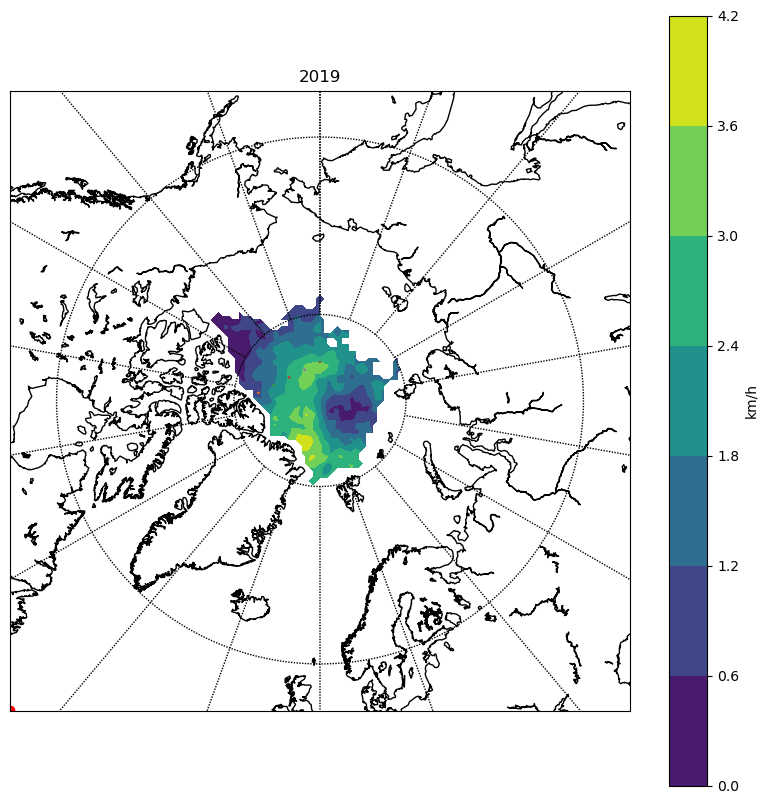

In [20]:
fig = plt.figure(figsize=(10,10))
plt.set_cmap('viridis')
m = Basemap(projection='npstere',boundinglat=55,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')

m.drawcoastlines()
#m.fillcontinents(color='0.1',lake_color='lightblue')

# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
#m.drawmapboundary(fill_color='lightblue')

lon_map,lat_map=m(lon_start[:,:],lat_start[:,:])
m.contourf(lon_map, lat_map, plotfield)

# COMPUTED TRAJECTORY FROM Uice Vice
for point_num in np.arange(0, num_points):
    a = np.ma.array(lons_df[point_num][0:2].values, mask=np.isnan(lons_df[point_num][0:2].values))
    b = np.ma.array(lats_df[point_num][0:2].values, mask=np.isnan(lats_df[point_num][0:2].values))
    lon_traj,lat_traj=m(a,b)
    #m.plot(lon_traj, lat_traj,'m')
    m.plot(lon_traj, lat_traj)
    
plt.plot(lons[0][0], lats_df[0][0], 'ro')

cbar=plt.colorbar()
cbar.set_label('km/h')
plt.title(f'{2019}')
plt.show()


Plot full trajectories:

/tmp/ipykernel_22210/3066309101.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(lons[0][0], lats_df[0][0], 'ro')


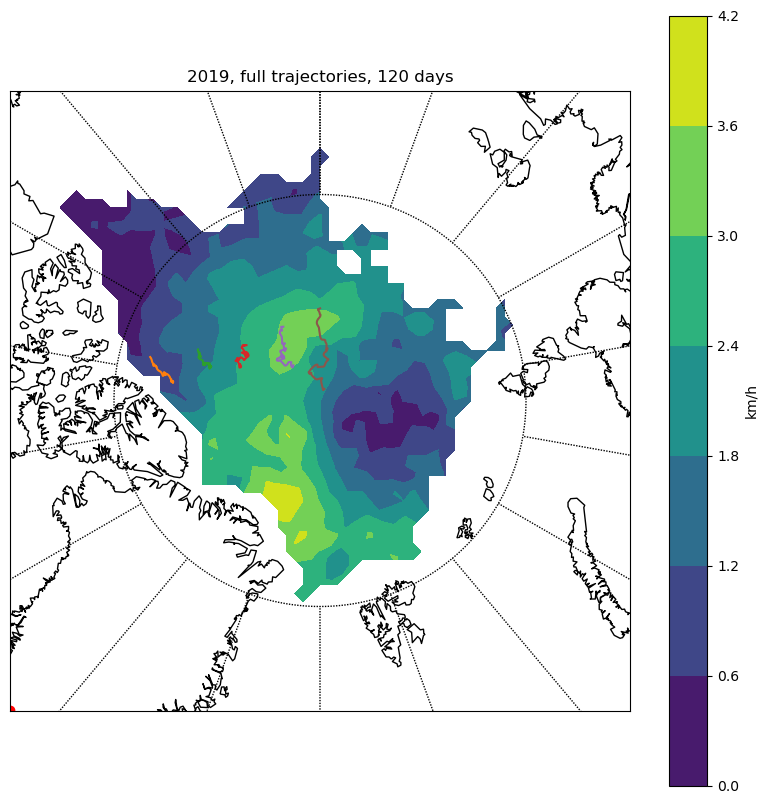

In [21]:
fig=plt.figure(figsize=(10,10))
m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
#m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')

m.drawcoastlines()
#m.fillcontinents(color='0.1',lake_color='lightblue')

# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
#m.drawmapboundary(fill_color='lightblue')

lon_map,lat_map=m(lon_start[:,:],lat_start[:,:])
m.contourf(lon_map, lat_map, plotfield)

# COMPUTED TRAJECTORY FROM Uice Vice
for point_num in np.arange(0, num_points):
    a = np.ma.array(lons_df[point_num][:].values, mask=np.isnan(lons_df[point_num][:].values))
    b = np.ma.array(lats_df[point_num][:].values, mask=np.isnan(lats_df[point_num][:].values))
    lon_traj,lat_traj=m(a,b)
    #m.plot(lon_traj, lat_traj,'m')
    m.plot(lon_traj, lat_traj)
    
plt.plot(lons[0][0], lats_df[0][0], 'ro')

cbar=plt.colorbar()
cbar.set_label('km/h')
plt.title(f'{2019}, full trajectories, {DAYS_TO_FORWARD} days')
plt.show()
